# Aplicação 2: Busca Multimodal em dados Médicos
Vamos utilizar do Pytorch Lightning de forma similar ao aprendido na aplicação 1, dessa vez para 
aprender a mapear uma representação gerada por um modelo de imagens com um modelo de texto, e possibilitar busca de imagens! 

In [29]:
import os
import glob
import math
import pandas as pd
import torch
import random
import logging
import torchinfo
import pytorch_lightning as pl
from pprint import pprint
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10
from transformers import BertModel, BertTokenizer
from efficientnet_pytorch import EfficientNet
from monai.losses import ContrastiveLoss
import matplotlib.pyplot as plt
import numpy as np
import medmnist
from medmnist import INFO, OrganAMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

In [11]:
# Desativando alguns warnings indesejados do transformers
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

In [12]:
# Dicionário de hiperparâmetros!
hparams = {"emb_size": 768,
           "batch_size": 4,
           "lr": 1e-4,
           "wd": 1e-5,
           "max_epochs": 10,
           "patience": 2,
           "num_workers": 1,
           "text_model_string": "emilyalsentzer/Bio_ClinicalBERT",
           "freeze_text_model": True,
           "image_model_string": "efficientnet-b0",
           "freeze_image_model": False,
           "size": 128}

# Dados

Criamos uma classe dataset e um datamodule para gerenciar os dados.

Os dados agora são fatias de orgãos em tomografia computadorizada, contendo uma label indicando o orgão. 

In [13]:
class MyOrganMNIST(Dataset):
    def __init__(self, mode, transform, size):
        print("Inicializando OrganMNIST...")

        os.makedirs("./data", exist_ok=True)
        # Baixa e carrega o dataset OrganAMNIST
        self.dataset = OrganAMNIST(root="./data", split='train' if mode == "train" else "test", transform=transform, download=True, size=size)

        print("Carregando o tokenizer...")
        self.tokenizer = BertTokenizer.from_pretrained(hparams["text_model_string"])
        print(f"Organ MNIST de {mode} inicializado.")
        self.metadata = INFO["organamnist"]
        pprint(self.metadata)
        self.classes = self.metadata["label"]

        # Calcula o comprimento máximo dos tokens de rótulo
        max_length = 0
        for label in self.classes.values():
            tokens = self.tokenizer(label)["input_ids"]
            max_length = max(max_length, len(tokens))
        self.max_length = max_length
        print(f"Comprimento máximo dos tokens de rótulo: {self.max_length}")

    def __len__(self):
        # Retorna o tamanho do dataset
        return len(self.dataset)

    def __getitem__(self, i):
        # Obtém uma imagem e um rótulo do dataset
        image, label = self.dataset[i]

        # Expande a imagem para 3 canais
        image = image.expand(3, -1, -1)

        # Por algum motivo, o rótulo é uma lista
        assert len(label) == 1
        label = str(label[0])

        # Obtém o texto correspondente ao rótulo
        text = self.classes[label]

        # Tokeniza o texto e o retorna junto com a imagem e o rótulo
        text_tokens = self.tokenizer(text, return_tensors="pt", max_length=self.max_length, padding="max_length")["input_ids"][0]

        return {"image": image,
                "label": label,
                "text": text,
                "text_tokens": text_tokens}


In [14]:
class OrganMNISTDataModule(pl.LightningDataModule):
    MEAN = [0.5]
    STD = [0.5]
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        
        # Define as transformações, incluindo a normalização dos dados
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=OrganMNISTDataModule.MEAN, std=OrganMNISTDataModule.STD)])

    def setup(self, stage):
        if stage == "fit":
            # Baixa e carrega os dados de treinamento
            self.train = MyOrganMNIST("train", self.transform, self.hparams["size"])
            # Baixa e carrega os dados de validação
            self.val = MyOrganMNIST("val", self.transform, self.hparams["size"])

    def train_dataloader(self):
        # Retorna o DataLoader para o conjunto de treinamento
        return DataLoader(self.train, batch_size=self.hparams["batch_size"], shuffle=True, num_workers=self.hparams["num_workers"])

    def val_dataloader(self):
        # Retorna o DataLoader para o conjunto de validação
        return DataLoader(self.val, batch_size=self.hparams["batch_size"], shuffle=False, num_workers=self.hparams["num_workers"])


In [15]:
# Inicializar data module e dataloader de teste
debug_datamodule = OrganMNISTDataModule(hparams)
debug_datamodule.prepare_data()
debug_datamodule.setup("fit")
debug_dataloader = debug_datamodule.train_dataloader()

Inicializando OrganMNIST...
Using downloaded and verified file: ./data/organamnist_128.npz
Carregando o tokenizer...
Organ MNIST de train inicializado.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
                'from another study to obtain the organ labels. '
                'Hounsfield-Unit (HU) of the 3D images are transformed into '
                'gray-scale with an abdominal window. We crop 2D images from '
                'the center slices of the 3D bounding boxes in axial views '
                '(planes). The images are resized into 

tensor([  101, 11911,   102,     0,     0,     0,     0])
tensor([ 101,  175, 5521, 2149,  118, 1268,  102])
tensor([  101, 16042,   118,  1286,   102,     0,     0])
tensor([  101, 16042,   118,  1286,   102,     0,     0])


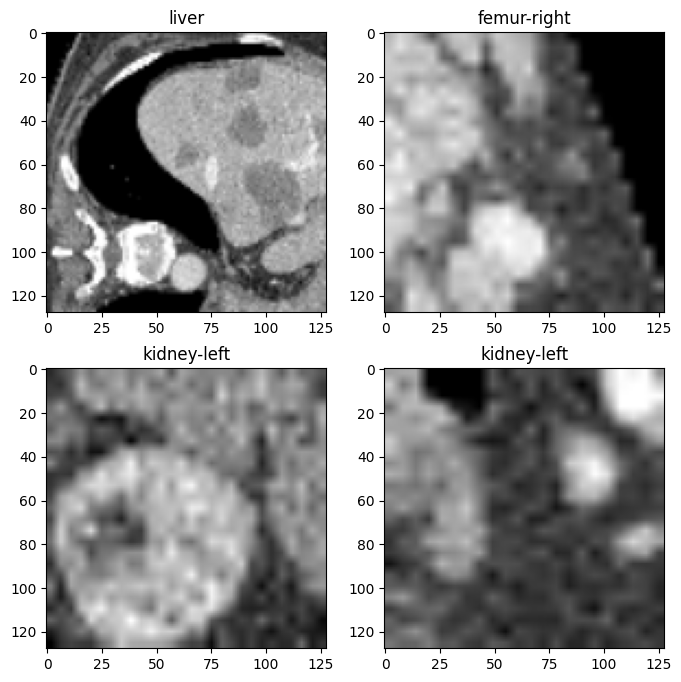

tensor([  101, 13093,   118,  1286,   102,     0,     0])
tensor([  101, 16042,   118,  1286,   102,     0,     0])
tensor([  101, 16042,   118,  1268,   102,     0,     0])
tensor([ 101,  188, 7136, 1424,  102,    0,    0])


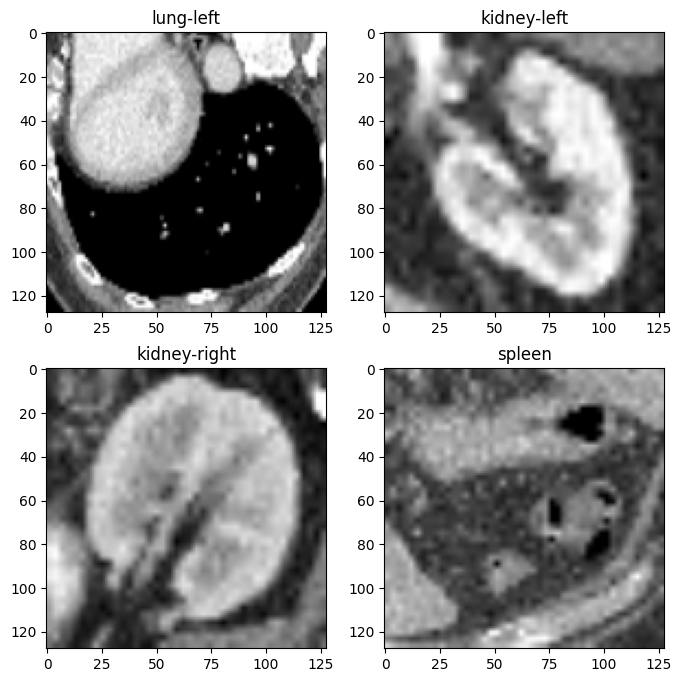

In [16]:
# Mostrar algumas imagens 
N_BATCHES_TO_DISPLAY = 2
for j, batch in enumerate(debug_dataloader):
    if j >= N_BATCHES_TO_DISPLAY:
        break
    B = batch["image"].shape[0]
    square_side = math.isqrt(B)
    plt.figure(figsize=(8, 8))
    for i, (image, text, tokens) in enumerate(zip(batch["image"], batch["text"], batch["text_tokens"])):
        visual_image = (image - image.min())/(image.max() - image.min())
        plt.subplot(square_side, square_side, i + 1)
        plt.imshow(visual_image.permute(1, 2, 0), cmap="gray")
        plt.title(text)
        pprint(tokens)
    plt.show()


In [17]:
class ImageModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        # Carrega o modelo de imagem predefinido (EfficientNet) usando a string fornecida em hparams
        self.image_model = EfficientNet.from_pretrained(hparams["image_model_string"])

        if hparams["freeze_image_model"]:
            print("Congelando o modelo de imagem")
            # Congela os parâmetros do modelo de imagem, impedindo que eles sejam atualizados durante o treinamento
            for param in self.image_model.parameters():
                param.requires_grad = False

        # As projeções de pesos não são congeladas
        # Substitui a camada final do modelo de imagem por uma nova camada linear para projetar para o tamanho de embedding desejado
        self.image_model._fc = nn.Linear(self.image_model._fc.in_features, hparams["emb_size"])

    def forward(self, x):
        # Passa a entrada pelo modelo de imagem e retorna a saída
        return self.image_model(x)


In [18]:
class TextModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        if hparams["freeze_text_model"]:
            print("Congelando o modelo de texto")
            # Carrega o modelo de texto pré-treinado (BERT) usando a string fornecida em hparams
            self.text_model = BertModel.from_pretrained(hparams["text_model_string"])
            # Congela os parâmetros do modelo de texto, impedindo que eles sejam atualizados durante o treinamento
            for param in self.text_model.parameters():
                param.requires_grad = False

    def forward(self, **kwargs):
        # Passa as entradas pelo modelo de texto e retorna a média dos estados ocultos da última camada
        return self.text_model(**kwargs).last_hidden_state.mean(dim=1)


In [19]:
torchinfo.summary(TextModel(hparams), depth=1)

Congelando o modelo de texto


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Param #
TextModel                                                    --
├─BertModel: 1-1                                             (108,310,272)
Total params: 108,310,272
Trainable params: 0
Non-trainable params: 108,310,272

In [20]:
torchinfo.summary(ImageModel(hparams), depth=1)

Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                                  Param #
ImageModel                                              --
├─EfficientNet: 1-1                                     4,991,356
Total params: 4,991,356
Trainable params: 4,991,356
Non-trainable params: 0

In [21]:
class LightningModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        # Salva os hiperparâmetros fornecidos
        self.save_hyperparameters(hparams)
        # Inicializa o modelo de imagem
        self.image_model = ImageModel(hparams)
        # Inicializa o modelo de texto
        self.text_model = TextModel(hparams)
        # Carrega o tokenizer para o modelo de texto
        self.tokenizer = BertTokenizer.from_pretrained(hparams["text_model_string"])

        # Define a função de perda como MSELoss (será que o ContrastiveLoss traria melhor performance?)
        self.loss = nn.MSELoss()

    def forward(self, batch):
        # Gera a representação da imagem usando o modelo de imagem
        image_repr = self.image_model(batch["image"])

        # Obtém os tokens de texto do batch
        tokens = batch["text_tokens"]

        # Gera a representação do texto usando o modelo de texto
        text_repr = self.text_model(input_ids=tokens)

        # Prepara o dicionário de retorno com a perda e as representações geradas
        return_dict = {}
        return_dict["loss"] = self.loss(image_repr, text_repr)
        return_dict["image_repr"] = image_repr
        return_dict["text_repr"] = text_repr

        return return_dict

    def query(self, query: str, image_batch):
        assert isinstance(query, str), 'A query deve ser uma string única'

        # Tokeniza e obtém a representação do texto (formato: [1, D])
        tokens = self.tokenizer(query, return_tensors="pt", padding=True, truncation=True)

        # Gera a representação do texto (formato: [D])
        text_repr = self.text_model(**tokens).squeeze(0)

        # Gera as representações das imagens (formato: [B, D])
        image_reprs = self.image_model(image_batch)

        # Expande text_repr para coincidir com o tamanho do batch de image_reprs. Sem cópia feita.
        text_repr_expanded = text_repr.unsqueeze(0).expand(image_reprs.size(0), -1)

        # Calcula as similaridades usando cosseno
        similarities = torch.cosine_similarity(text_repr_expanded, image_reprs)

        # Retorna a imagem top-1 (mais similar)
        index = similarities.argmax()

        return similarities, index

    def training_step(self, batch, batch_idx):
        # Executa o passo de treinamento e calcula a perda
        outputs = self.forward(batch)
        loss = outputs["loss"]
        # Loga a perda de treinamento
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # Executa o passo de validação e calcula a perda
        outputs = self.forward(batch)
        loss = outputs["loss"]
        # Loga a perda de validação
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        # Configura o otimizador AdamW com os hiperparâmetros fornecidos
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams["lr"], weight_decay=self.hparams["wd"])

        return optimizer


In [23]:
# Teste se a função de query funciona!
lightning_module = LightningModule(hparams)
sample_batch = torch.ones(size=(2, 3, 224, 224))
sample_texts = ["Hello World", "Apple"]
query = "Hello!"
lightning_module.query(query, sample_batch)


Loaded pretrained weights for efficientnet-b0
Congelando o modelo de texto


(tensor([-0.0024,  0.0768], grad_fn=<SumBackward1>), tensor(1))

In [25]:
# Inicializa o módulo Lightning com os hiperparâmetros fornecidos
lightning_module = LightningModule(hparams)

# Inicializa o DataModule com os hiperparâmetros fornecidos
datamodule = OrganMNISTDataModule(hparams)

# Early Stopping (Parada Antecipada)
# Monitora a perda de validação ('val_loss') e interrompe o treinamento
# se a perda não melhorar após um número de épocas definido por 'patience'
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    patience=hparams["patience"],
                                    verbose=True,
                                    mode='min')

# Model Checkpoint
# Salva o melhor modelo durante o treinamento baseado na menor perda de validação ('val_loss')
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='artifacts/checkpoints2',
                                      filename='medical_embedding_search-weight-{epoch}-{val_loss:.2f}',
                                      save_top_k=1,  # Salva apenas o melhor modelo
                                      mode='min')

# CSV Logger
# Registra os logs de treinamento e validação em um arquivo CSV para posterior análise
csv_logger = CSVLogger("artifacts/checkpoints2", name="model")

# Trainer com callbacks e logger
# Configura o Trainer do PyTorch Lightning para gerenciar o treinamento com os callbacks de Early Stopping e Model Checkpoint, 
# além de registrar os logs de cada época.
trainer = pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback],
                     logger=csv_logger,
                     max_epochs=hparams["max_epochs"],  # Número máximo de épocas
                     accelerator="gpu",  # Define o uso da CPU para o treinamento
                     devices=1)  # Define o número de dispositivos (neste caso, uma única CPU)


Loaded pretrained weights for efficientnet-b0
Congelando o modelo de texto


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(lightning_module, datamodule)

Inicializando OrganMNIST...
Using downloaded and verified file: ./data/organamnist_128.npz
Carregando o tokenizer...
Organ MNIST de train inicializado.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
                'from another study to obtain the organ labels. '
                'Hounsfield-Unit (HU) of the 3D images are transformed into '
                'gray-scale with an abdominal window. We crop 2D images from '
                'the center slices of the 3D bounding boxes in axial views '
                '(planes). The images are resized into 

/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/diedre/minicurso_dl_medical/artifacts/checkpoints2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | image_model | ImageModel | 5.0 M  | train
1 | text_model  | TextModel  | 108 M  | train
2 | loss        | MSELoss    | 0      | train
---------------------------------------------------
5.0 M     Trainable params
108 M     Non-trainable params
113 M     Total params
453.207   Total estimated model params size (MB)
252       Modules in train mode
228       Modules in eval mode


Organ MNIST de val inicializado.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
                'from another study to obtain the organ labels. '
                'Hounsfield-Unit (HU) of the 3D images are transformed into '
                'gray-scale with an abdominal window. We crop 2D images from '
                'the center slices of the 3D bounding boxes in axial views '
                '(planes). The images are resized into 1×28×28 to perform '
                'multi-class classification of 11 body organs. 115 and 16 CT '
                'sc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.008

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [27]:
from pprint import pprint

In [30]:
# Debug query module
trained_model = LightningModule.load_from_checkpoint(random.choice(glob.glob("artifacts/checkpoints2/*.ckpt")))
loaded_hparams = trained_model.hparams
pprint(loaded_hparams)

# Inicializar o dado com parametros correspondendo ao peso treinado
query_datamodule = OrganMNISTDataModule(loaded_hparams)

query_datamodule.prepare_data()
query_datamodule.setup("fit")
query_dataloader = query_datamodule.val_dataloader()

Loaded pretrained weights for efficientnet-b0
Congelando o modelo de texto


/home/diedre/miniconda3/envs/cbeb/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


"batch_size":         4
"emb_size":           768
"freeze_image_model": False
"freeze_text_model":  True
"image_model_string": efficientnet-b0
"lr":                 0.0001
"max_epochs":         10
"num_workers":        1
"patience":           2
"size":               128
"text_model_string":  emilyalsentzer/Bio_ClinicalBERT
"wd":                 1e-05
Inicializando OrganMNIST...
Using downloaded and verified file: ./data/organamnist_128.npz
Carregando o tokenizer...
Organ MNIST de train inicializado.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
  

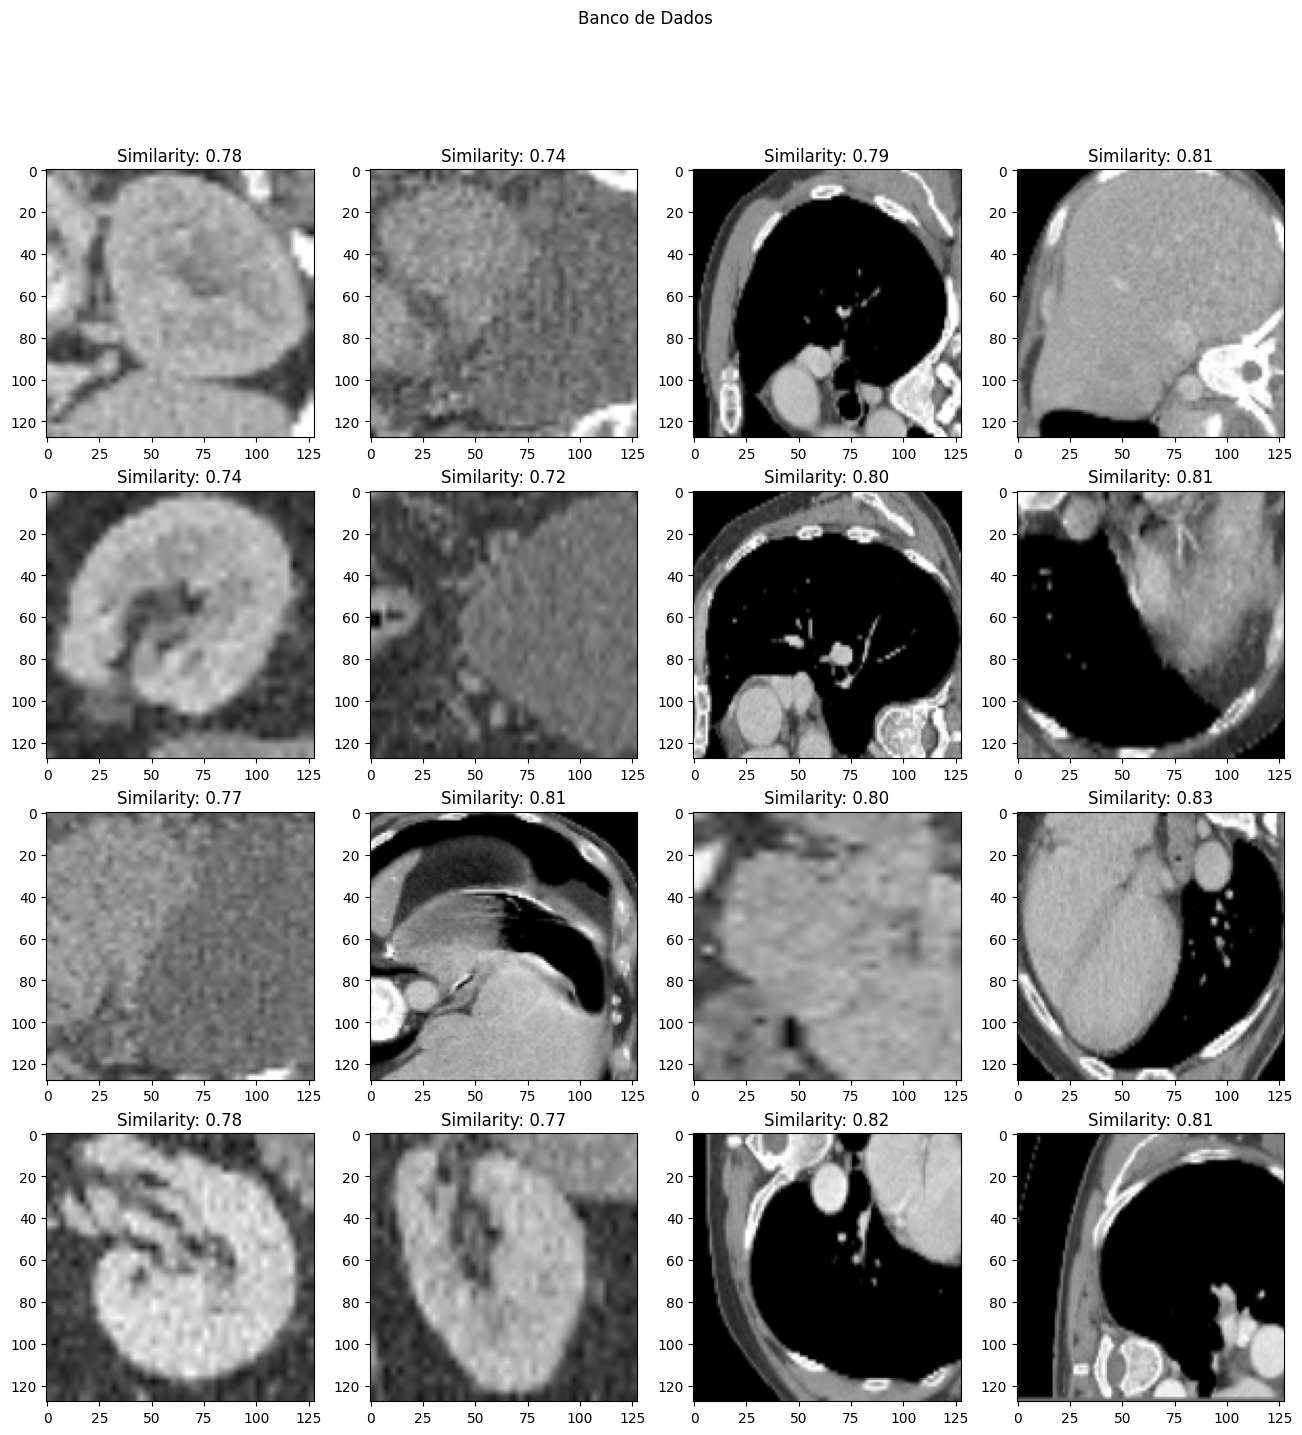

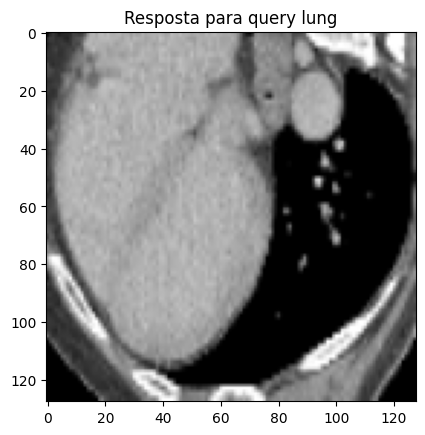

In [32]:
# Denormalizar as imagens para visualização após a predição
# As médias (MEAN) e desvios padrão (STD) usados na normalização original são ajustados para o formato correto
MEAN, STD = torch.tensor(OrganMNISTDataModule.MEAN).view(1, 1, 1, 1), torch.tensor(OrganMNISTDataModule.STD).view(1, 1, 1, 1)

# Define a query (consulta) que será usada para buscar a imagem mais similar no banco de dados
query = "lung"

# Cria um iterador para o DataLoader de consulta
iter_dl = iter(query_dataloader)

# Extrai um batch de amostras do DataLoader para realizar a consulta
sample_batch = torch.cat([next(iter_dl)["image"] for _ in range(4)], dim=0)

# Realiza a consulta usando o módulo Lightning e obtém a similaridade e o índice da imagem mais similar
similarity, index = lightning_module.query(query, sample_batch)

# Denormalizando para visualização!
# As imagens são denormalizadas para serem visualizadas no formato original
denormalized_images = (sample_batch * STD) + MEAN

# Configura a figura para exibir as imagens do banco de dados
plt.figure(figsize=(16, 16))
plt.suptitle("Banco de Dados")
side = math.isqrt(len(denormalized_images))  # Calcula o tamanho da grade para exibição
for i, image in enumerate(denormalized_images):
    plt.subplot(side, side, i + 1)
    # Exibe a imagem denormalizada
    plt.imshow(image.permute(1, 2, 0))
    # Exibe a similaridade calculada para cada imagem
    plt.title(f"Similarity: {similarity[i].item():.2f}")

# Exibe a imagem que teve a maior similaridade com a query
plt.figure()
plt.imshow(denormalized_images[index].permute(1, 2, 0))
plt.title(f"Resposta para query {query}")
plt.show()


# Resultados melhores poderiam ser alcançados com uma Contrastive Loss! 